In [1]:
import argparse
import io
import os
import yaml
import sys
from pathlib import Path
from datetime import datetime


import numpy as np
import pandas as pd
from tqdm import tqdm

import wandb
from omegaconf import OmegaConf


from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, WeightedRandomSampler

from torch_geometric.loader import DataLoader

# --------------------- Custom imports --------------------- #
# Add the root directory to path

from src.data.dataset_graph import GraphEEGDataset

c:\Users\beaiz\Anaconda3\envs\nml_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
DATA_ROOT = Path("data")
train_dir = DATA_ROOT / "train"
train_dir_metadata = train_dir / "segments.parquet"
train_dataset_dir = DATA_ROOT / "graph_dataset_train"
spatial_distance_file = DATA_ROOT / "distances_3d.csv"
extracted_features_dir = DATA_ROOT / "extracted_features"
embeddings_dir =  DATA_ROOT / "embeddings"
channels = [
            "FP1",
            "FP2",
            "F3",
            "F4",
            "C3",
            "C4",
            "P3",
            "P4",
            "O1",
            "O2",
            "F7",
            "F8",
            "T3",
            "T4",
            "T5",
            "T6",
            "FZ",
            "CZ",
            "PZ",
        ]


In [21]:
    # ----------------- Prepare training data -----------------#

clips_tr = pd.read_parquet(train_dir_metadata)
clips_tr = clips_tr[~clips_tr.label.isna()].reset_index()[:100]  # Filter NaN values out of clips_tr
edge_strategy = 'spatial'
    # -------------- Dataset definition -------------- #
dataset = GraphEEGDataset(
        root=train_dataset_dir,
        clips=clips_tr,
        signal_folder=train_dir,
        extracted_features_dir=extracted_features_dir,
        selected_features_train=True,
        embeddings_dir = embeddings_dir,
        embeddings_train = False,
    edge_strategy=edge_strategy,
    spatial_distance_file=(
        spatial_distance_file if edge_strategy == "spatial" else None
    ),
    top_k=4,
    correlation_threshold=False,
    force_reprocess=True,
    bandpass_frequencies=(
        0.5,
       50,
    ),
    segment_length=3000,
    apply_filtering=True,
    apply_rereferencing=True,
    apply_normalization=True,
    sampling_rate=250,
)

IndexError: index 100 is out of bounds for axis 0 with size 100

In [16]:
def load_distance_matrix(path, channels):
    df = pd.read_csv(path)
    n = len(channels)
    ch_to_idx = {ch: i for i, ch in enumerate(channels)}
    dist_matrix = np.full((n, n), np.inf)

    for _, row in df.iterrows():
        ch1, ch2 = row["from"], row["to"]
        if ch1 in ch_to_idx and ch2 in ch_to_idx:
            i, j = ch_to_idx[ch1], ch_to_idx[ch2]
            dist_matrix[i, j] = row["distance"]
            dist_matrix[j, i] = row["distance"]  # symmetric

    return dist_matrix

from sklearn.manifold import MDS

def compute_2d_positions_from_distances(dist_matrix):
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(dist_matrix)  # shape: (n_channels, 2)
    return coords
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph_with_mds(data, channels, coords_2d):
    """
    Visualize EEG graph using 2D coordinates estimated by MDS.

    Args:
        data (torch_geometric.data.Data): Graph data with edge_index
        channels (list[str]): Ordered list of channel names
        coords_2d (ndarray): 2D positions of shape (n_channels, 2)
    """
    G = to_networkx(data, to_undirected=True)

    pos = {i: tuple(coords_2d[i]) for i in range(len(channels))}
    labels = {i: ch for i, ch in enumerate(channels)}

    plt.figure(figsize=(7, 7))
    nx.draw(
        G, pos,
        labels=labels,
        with_labels=True,
        node_color="skyblue",
        edge_color="gray",
        node_size=700,
        font_size=9
    )
    plt.title("EEG Graph with Head-Based Layout (MDS)")
    plt.axis('equal')
    plt.show()


c:\Users\beaiz\Anaconda3\envs\nml_env\lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


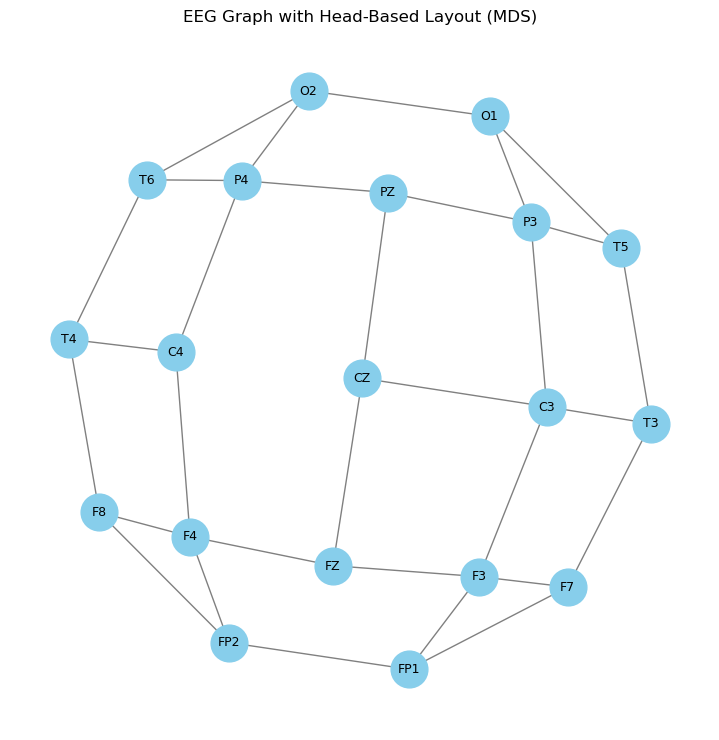

In [19]:
dist_matrix = load_distance_matrix(spatial_distance_file, channels)
coords_2d = compute_2d_positions_from_distances(dist_matrix)
visualize_graph_with_mds(dataset[0], channels, coords_2d)

In [11]:
distances = pd.read_csv(spatial_distance_file)
distances

,from,to,distance
0,FP1,FP1,0.000000
1,FP1,FP2,0.618000
2,FP1,F3,0.618969
3,FP1,F4,1.030322
4,FP1,C3,1.250226
...,...,...,...
356,PZ,T5,1.081066
357,PZ,T6,1.081066
358,PZ,FZ,1.414200
359,PZ,CZ,0.765363


In [8]:

def load_channel_positions(distance_file):
    df = pd.read_csv(distance_file)
    pos_2d = {row["channel"]: (row["x"], row["y"]) for _, row in df.iterrows()}
    return pos_2d

load_channel_positions(spatial_distance_file)


KeyError: 'channel'

In [4]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph(data, layout='circular'):
    G = to_networkx(data, to_undirected=True)

    # Layout
    if layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G)

    # Plot
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')



    plt.title("EEG Graph")
    plt.show()



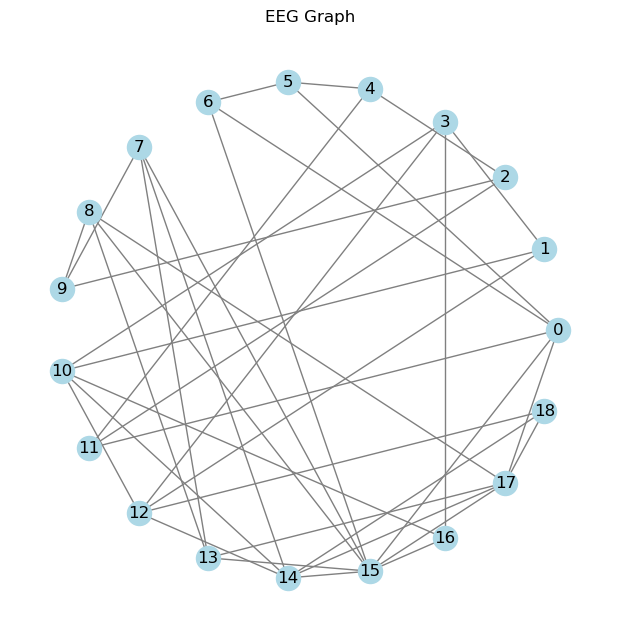

In [7]:
graph = dataset[8]
visualize_graph(graph)